### Importing necessary Modules for database and name generation

In [3]:
from pymongo import MongoClient
import random
import string
import time
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from scipy.stats import mannwhitneyu



#### Connecting to the mongodb on standard localhost 

This code connects to the user_info_db database and retrieves the user_info collection


In [4]:
# Connect to MongoDB (default host and port: localhost:27017)
client = MongoClient('mongodb://localhost:27017/')
# Create or access the 'user_info_db' database
db = client['user_info_db']

Initializing the collections used



In [5]:
collection_50 = db['user_info_50']
collection_500 = db['user_info_500']
collection_5000 = db['user_info_5000']

classical_search_50 = db['classical_search_50']
classical_search_500 = db['classical_search_500']
classical_search_5000 = db['classical_search_5000']


grover_search_50 = db['grover_search_50']  
grover_search_500 = db['grover_search_500']
grover_search_5000 = db['grover_search_5000']


Helper function to generate names

In [6]:
def generate_random_name(length=6):
    """Generate a random name of a specified length"""
    return ''.join(random.choices(string.ascii_uppercase, k=length))

### All collection insertions

In [22]:
# Insertion function for 'user_info_50'
def insert_user_info_50():
    collection_50.delete_many({})  # Clear any existing data
    names_50 = [{"name": generate_random_name()} for _ in range(50)]
    collection_50.insert_many(names_50)
    print("Inserted 50 names into user_info_50.")

# Insertion function for 'user_info_500'
def insert_user_info_500():
    collection_500.delete_many({})  # Clear any existing data
    names_500 = [{"name": generate_random_name()} for _ in range(500)]
    collection_500.insert_many(names_500)
    print("Inserted 500 names into user_info_500.")

# Insertion function for 'user_info_5000'
def insert_user_info_5000():
    collection_5000.delete_many({})  # Clear any existing data
    names_5000 = [{"name": generate_random_name()} for _ in range(5000)]
    collection_5000.insert_many(names_5000)
    print("Inserted 5000 names into user_info_5000.")

# inserting
insert_user_info_50()
insert_user_info_500()
insert_user_info_5000()



Inserted 50 names into user_info_50.
Inserted 500 names into user_info_500.
Inserted 5000 names into user_info_5000.


### Creating the target lists

In [23]:
# Step 2: Create the target name lists
# Helper function to create target lists (existing + non-existing names)
def create_target_name_list(collection_name, total_names):
    collection = db[collection_name]
    existing_names = [user["name"] for user in collection.find()]
    print(f"Existing names in {collection_name}: {existing_names[:10]}")  # Displaying first 10 names for inspection
    
    # Generate non-existing names
    new_non_existing_names = set()
    while len(new_non_existing_names) < total_names // 2:  # Half will be non-existing
        new_name = generate_random_name()
        if new_name not in existing_names:
            new_non_existing_names.add(new_name)
    
    target_name_list = existing_names[:total_names // 2] + list(new_non_existing_names)
    random.shuffle(target_name_list)  # Shuffle the list to mix existing and new names
    return target_name_list

# Creating target name lists
target_name_list_50 = create_target_name_list('user_info_50', 100)
target_name_list_500 = create_target_name_list('user_info_500', 1000)
target_name_list_5000 = create_target_name_list('user_info_5000', 10000)

# Verifying the lists
print(f"Target name list for user_info_50 (100 names): {target_name_list_50[:10]}...")  # Displaying first 10 names for inspection
print(f"Target name list for user_info_500 (1000 names): {target_name_list_500[:10]}...")
print(f"Target name list for user_info_5000 (10000 names): {target_name_list_5000[:10]}...")

Existing names in user_info_50: ['NUTODN', 'RXHRFM', 'PNVSWG', 'WTRJMH', 'UCBSHX', 'UQDQNL', 'WRMXCO', 'MUFWTP', 'PIZCIV', 'GPHIZE']
Existing names in user_info_500: ['NUDYHX', 'LBBCOY', 'JBEXMI', 'UELWAO', 'JJNLPD', 'IUJNWD', 'SHHAGJ', 'JBYVXK', 'AGTXJS', 'GPEZDX']
Existing names in user_info_5000: ['QRWBAL', 'JJYBDX', 'QGKLWN', 'PXZLJE', 'BRMEHE', 'JXMBWT', 'FLASFD', 'FSCNBR', 'ZKMJUZ', 'MLTOEC']
Target name list for user_info_50 (100 names): ['IUXONF', 'NVFVWD', 'PKGSIG', 'VDNSVV', 'QMPGOK', 'UROMEA', 'QCRTGV', 'KZYAMI', 'NSJAES', 'RXHRFM']...
Target name list for user_info_500 (1000 names): ['EWHVIV', 'ZLSSJS', 'QYAYSS', 'AHHSUD', 'UJGMGQ', 'MRHWEW', 'IWJYOD', 'XPEWFI', 'NKRFII', 'COZIKN']...
Target name list for user_info_5000 (10000 names): ['RKMBHM', 'LMFGBW', 'DUJIQS', 'XVUFGD', 'VRSBQX', 'PFTDKC', 'QSPYIA', 'DPHFDQ', 'OQSBSG', 'STQBSV']...


## Classical Approach O(N)

In [24]:
# Function for classical search algorithm (O(n) linear search)
def classical_search(collection, target_name):
    start_time = time.perf_counter()
    found = False
    for user in collection.find():
        if user["name"] == target_name:
            found = True
            break
    end_time = time.perf_counter()
    time_taken_us = (end_time - start_time) * 1_000_000  # Convert to microseconds
    return found, time_taken_us


# Insert search results into a collection
def insert_search_results(collection_name, target_name, found, time_taken):
    collection = db[collection_name]
    
    collection.insert_one({
        'name': target_name,
        'found': found,
        'TimeTaken': time_taken  # Time in microseconds
    })


# Classical search for the target lists and store results
def run_classical_search():
    # Clear and process for user_info_50
    classical_search_50.delete_many({})
    for target_name in target_name_list_50:
        found, time_taken = classical_search(collection_50, target_name)
        insert_search_results('classical_search_50', target_name, found, time_taken)

    # Clear and process for user_info_500
    classical_search_500.delete_many({})
    for target_name in target_name_list_500:
        found, time_taken = classical_search(collection_500, target_name)
        insert_search_results('classical_search_500', target_name, found, time_taken)

    # Clear and process for user_info_5000
    classical_search_5000.delete_many({})
    for target_name in target_name_list_5000:
        found, time_taken = classical_search(collection_5000, target_name)
        insert_search_results('classical_search_5000', target_name, found, time_taken)

# Run the classical search and insert results
run_classical_search()


### Organizing the data

In [25]:
# Function to retrieve data from a collection
def get_search_data(collection_name):
    collection = db[collection_name]
    search_results = collection.find()  # Query all documents
    return list(search_results)

# Retrieve data for all three collections
data_50 = get_search_data('classical_search_50')
data_500 = get_search_data('classical_search_500')
data_5000 = get_search_data('classical_search_5000')

# Extract times and found status for plotting
def extract_times_and_found_status(data):
    times = []
    found = []
    for record in data:
        times.append(record['TimeTaken'])  # Assuming field is named 'time_taken' in microseconds
        found.append(record['found'])  # Assuming field is named 'found'
    return times, found

# Extract data for each collection
times_50, found_50 = extract_times_and_found_status(data_50)
times_500, found_500 = extract_times_and_found_status(data_500)
times_5000, found_5000 = extract_times_and_found_status(data_5000)



### Plotting the data

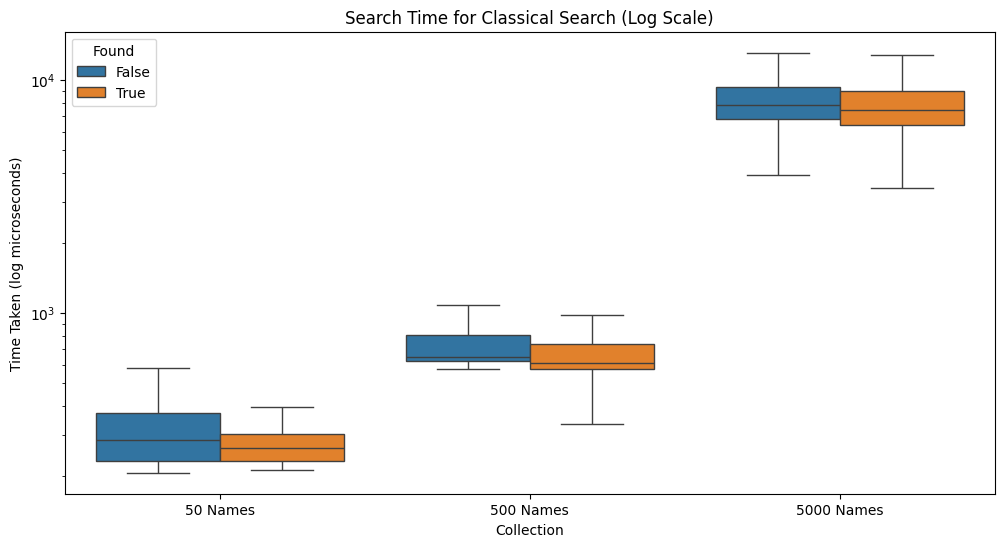

In [26]:
# Function to create DataFrame for plotting
def create_df_for_plot(times, found, collection_name):
    df = pd.DataFrame({
        'Time Taken (microseconds)': times,  # Show time in microseconds
        'Found': found,
        'Collection': [collection_name] * len(times)
    })
    return df

# Create DataFrames for each collection
df_50 = create_df_for_plot(times_50, found_50, '50 Names')
df_500 = create_df_for_plot(times_500, found_500, '500 Names')
df_5000 = create_df_for_plot(times_5000, found_5000, '5000 Names')

# Combine DataFrames
df_all = pd.concat([df_50, df_500, df_5000])

# Plot using Seaborn
# Plot with capped y-axis and IQR emphasis
plt.figure(figsize=(12, 6))
sns.boxplot(x='Collection', y='Time Taken (microseconds)', hue='Found', data=df_all, showfliers=False)
plt.yscale('log')  # Apply logarithmic scale
plt.title('Search Time for Classical Search (Log Scale)')
plt.ylabel('Time Taken (log microseconds)')
plt.show()




### STATS

In [27]:
def print_stats(collection_name):
    collection = db[collection_name]
    data = list(collection.find())
    df = pd.DataFrame(data)  # Convert data to DataFrame

    print(f"\nStatistics for {collection_name}:")
    mean = df['TimeTaken'].mean()
    median = df['TimeTaken'].median()
    std_dev = df['TimeTaken'].std()
    min_val = df['TimeTaken'].min()
    max_val = df['TimeTaken'].max()
    iqr = df['TimeTaken'].quantile(0.75) - df['TimeTaken'].quantile(0.25)

    print(f"Mean Time: {mean:.5f} µs")
    print(f"Median Time: {median:.5f} µs")
    print(f"Standard Deviation: {std_dev:.5f} µs")
    print(f"Min Time: {min_val:.5f} µs")
    print(f"Max Time: {max_val:.5f} µs")
    print(f"IQR (Interquartile Range): {iqr:.5f} µs")

# Mann-Whitney U test function to compare found vs not found (using microseconds)
def mann_whitney_test(collection_name):
    collection = db[collection_name]
    data = list(collection.find())
    df = pd.DataFrame(data)

    found_times = df[df['found'] == True]['TimeTaken']
    not_found_times = df[df['found'] == False]['TimeTaken']

    if len(found_times) > 0 and len(not_found_times) > 0:  # Ensure data exists
        stat, p_value = mannwhitneyu(found_times, not_found_times, alternative='two-sided')
        return p_value
    else:
        print(f"Not enough data in {collection_name} for Mann-Whitney U test.")
        return None
# Print stats for each collection
print_stats('classical_search_50')
print_stats('classical_search_500')
print_stats('classical_search_5000')

# Perform Mann-Whitney U tests
p_value_50 = mann_whitney_test('classical_search_50')
p_value_500 = mann_whitney_test('classical_search_500')
p_value_5000 = mann_whitney_test('classical_search_5000')

# Print p-values
print(f"\nP-Value for classical_search_50: {p_value_50:.5f}")
print(f"P-Value for classical_search_500: {p_value_500:.5f}")
print(f"P-Value for classical_search_5000: {p_value_5000:.5f}")



Statistics for classical_search_50:
Mean Time: 371.08623 µs
Median Time: 274.85448 µs
Standard Deviation: 469.71187 µs
Min Time: 206.29121 µs
Max Time: 4378.74999 µs
IQR (Interquartile Range): 89.82298 µs

Statistics for classical_search_500:
Mean Time: 813.81434 µs
Median Time: 631.72937 µs
Standard Deviation: 3440.00921 µs
Min Time: 191.58423 µs
Max Time: 106842.16698 µs
IQR (Interquartile Range): 167.44836 µs

Statistics for classical_search_5000:
Mean Time: 11775.12377 µs
Median Time: 7642.60348 µs
Standard Deviation: 13885.39905 µs
Min Time: 274.79185 µs
Max Time: 93398.37497 µs
IQR (Interquartile Range): 2530.13533 µs

P-Value for classical_search_50: 0.15357
P-Value for classical_search_500: 0.00000
P-Value for classical_search_5000: 0.00000


## Grovers Search below

In [9]:
from qiskit import QuantumCircuit
from qiskit.visualization import plot_histogram
from qiskit_aer import AerSimulator
from qiskit.circuit.library import MCXGate

In [15]:

def grover_search_algorithm(collection, target_name_list, grover_collection):
    names = [user["name"] for user in collection.find()]
    # Create a mapping of the names to indices for quantum representation
    name_to_index = {name: i for i, name in enumerate(names)}
    grover_collection.delete_many({})

    # Number of qubits needed is based on the number of possible names
    n = len(names)  # number of names in the database
    n_qubits = n.bit_length()  # number of qubits needed

    # Grover's Oracle: Phase-flip (controlled-Z gate) for the target state
    def grover_oracle(circuit, n_qubits, target_index):
        """Mark the state corresponding to the target index (the solution) with a phase flip."""
        # Apply X gates to flip the qubits based on the target index
        for qubit in range(n_qubits):
            if (target_index >> qubit) & 1:
                circuit.x(qubit)

        # Apply Hadamard to the last qubit (ancilla) before the multi-controlled Toffoli
        circuit.h(n_qubits - 1)
        
        # Apply multi-controlled Toffoli gate (MCX) to flip the target state
        # The MCXGate is an implementation for the multi-controlled X gate
        circuit.mcx(list(range(n_qubits - 1)), n_qubits - 1)  # Multi-controlled Toffoli (MCX)

        # Apply Hadamard to the last qubit (ancilla) after the multi-controlled Toffoli
        circuit.h(n_qubits - 1)

        # Revert the X gates to restore the original qubits state
        for qubit in range(n_qubits):
            if (target_index >> qubit) & 1:
                circuit.x(qubit)

    # Grover's Diffusion Operator: Inversion about the mean
    def grover_diffusion(circuit, n_qubits):
        """Apply the diffusion operator."""
        # Apply Hadamard and X gates to all qubits
        for qubit in range(n_qubits):
            circuit.h(qubit)
            circuit.x(qubit)

        # Apply the multi-controlled Toffoli (inversion about the mean)
        circuit.h(n_qubits - 1)
        circuit.mcx(list(range(n_qubits - 1)), n_qubits - 1)
        circuit.h(n_qubits - 1)

        # Apply X and Hadamard gates to all qubits to complete the diffusion
        for qubit in range(n_qubits):
            circuit.x(qubit)
            circuit.h(qubit)

    # Function to insert search results into MongoDB
    def insert_search_result(target_name, found, time_taken):
        """Insert the search result into the appropriate MongoDB collection"""
        document = {
            "TargetName": target_name,
            "Found": found,
            "TimeTaken": time_taken
        }
        
        # Insert the document into the provided collection
        grover_collection.insert_one(document)

    # Grover's search algorithm with insertion into MongoDB
    def grover_search_and_insert(names, target_name):
        # Initialize the quantum circuit
        n = len(names)
        n_qubits = n.bit_length()  # Number of qubits needed for the database size
        qc = QuantumCircuit(n_qubits, n_qubits)
        
        # Apply Hadamard to all qubits to create the superposition
        qc.h(range(n_qubits))
        
        # Perform Grover's algorithm iterations
        target_index = name_to_index.get(target_name, None)
        
        # Handle the case when the target name is not found
        if target_index is None:
            found = False
        else:
            # Apply Grover's Oracle and Diffusion operator
            grover_oracle(qc, n_qubits, target_index)
            grover_diffusion(qc, n_qubits)
            found = True
        
        # Measure the qubits
        qc.measure(range(n_qubits), range(n_qubits))
        
        # Use the Aer's qasm_simulator to simulate the result
        simulator = AerSimulator()  # Using AerSimulator instead of Aer.get_backend
        start_time = time.perf_counter()  # Start time for execution
        result = simulator.run(qc, shots=1024).result()
        elapsed_time_ms = (time.perf_counter() - start_time) * 1_000_000  # Time in microseconds
        
        # Display the results (showing only key output)
        counts = result.get_counts(qc)
        
        # If the target was found, check if the corresponding binary index is in the results
        if found:
            binary_target = format(target_index, '0{}b'.format(n_qubits))
            found_in_results = binary_target in counts
        
        # Insert the search result into the MongoDB collection
        insert_search_result(target_name, found, elapsed_time_ms)

    # Loop through the list of target names and perform Grover's search
    for target_name in target_name_list:
        grover_search_and_insert(names, target_name)

# Perform Grover search for each collection with their respective target name lists
grover_search_algorithm(collection_50, target_name_list_50, grover_search_50)
grover_search_algorithm(collection_500, target_name_list_500, grover_search_500)
grover_search_algorithm(collection_5000, target_name_list_5000, grover_search_5000)

print("Grover finished")

Grover finished


### Organizing the data

In [11]:
# Function to retrieve data from a collection
def get_search_data(collection_name):
    collection = db[collection_name]
    search_results = collection.find()  # Query all documents
    return list(search_results)

# Retrieve data for the grover_search_50, grover_search_500, and grover_search_5000 collections
data_grover_50 = get_search_data('grover_search_50')
data_grover_500 = get_search_data('grover_search_500')
data_grover_5000 = get_search_data('grover_search_5000')

# Extract times and found status for plotting
def extract_times_and_found_status(data):
    times = []
    found = []
    for record in data:
        times.append(record['TimeTaken'])  # Assuming field is named 'TimeTaken' in microseconds
        found.append(record['Found'])  # Assuming field is named 'Found'
    return times, found

# Extract data for all three collections
times_grover_50, found_grover_50 = extract_times_and_found_status(data_grover_50)
times_grover_500, found_grover_500 = extract_times_and_found_status(data_grover_500)
times_grover_5000, found_grover_5000 = extract_times_and_found_status(data_grover_5000)


### Plotting the data

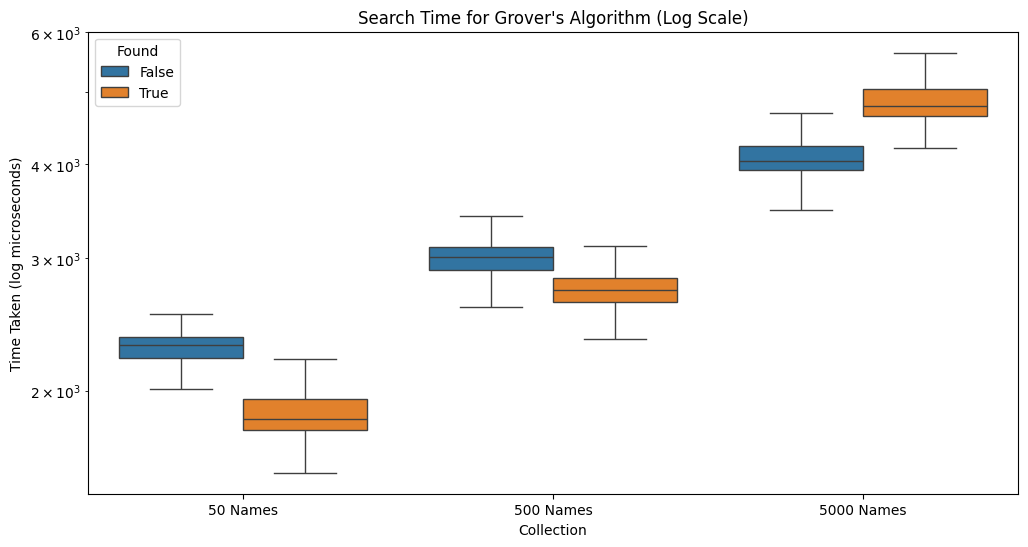

In [12]:
# Function to create DataFrame for plotting
def create_df_for_plot(times, found, collection_name):
    df = pd.DataFrame({
        'Time Taken (microseconds)': times,  # Show time in microseconds
        'Found': found,
        'Collection': [collection_name] * len(times)
    })
    return df

# Create DataFrames for all collections
df_grover_50 = create_df_for_plot(times_grover_50, found_grover_50, '50 Names')
df_grover_500 = create_df_for_plot(times_grover_500, found_grover_500, '500 Names')
df_grover_5000 = create_df_for_plot(times_grover_5000, found_grover_5000, '5000 Names')

# Combine the DataFrames
df_all = pd.concat([df_grover_50, df_grover_500, df_grover_5000], ignore_index=True)

# Plot using Seaborn
plt.figure(figsize=(12, 6))
sns.boxplot(x='Collection', y='Time Taken (microseconds)', hue='Found', data=df_all, showfliers=False)
plt.yscale('log')  # Apply logarithmic scale
plt.title('Search Time for Grover\'s Algorithm (Log Scale)')
plt.ylabel('Time Taken (log microseconds)')
plt.show()


### Statistical information

In [13]:
# Assuming df_grover_50, df_grover_500, and df_grover_5000 are already available from previous code

# Function to calculate and print stats (now in microseconds)
def print_stats(collection_name, df):
    print(f"\nStatistics for {collection_name}:")
    mean = df['Time Taken (microseconds)'].mean()  # In microseconds
    median = df['Time Taken (microseconds)'].median()
    std_dev = df['Time Taken (microseconds)'].std()
    min_val = df['Time Taken (microseconds)'].min()
    max_val = df['Time Taken (microseconds)'].max()
    iqr = df['Time Taken (microseconds)'].quantile(0.75) - df['Time Taken (microseconds)'].quantile(0.25)

    print(f"Mean Time: {mean:.5f} µs")
    print(f"Median Time: {median:.5f} µs")
    print(f"Standard Deviation: {std_dev:.5f} µs")
    print(f"Min Time: {min_val:.5f} µs")
    print(f"Max Time: {max_val:.5f} µs")
    print(f"IQR (Interquartile Range): {iqr:.5f} µs")


# Mann-Whitney U test function to compare found vs not found (using microseconds)
def mann_whitney_test(collection_df):
    found_times = collection_df[collection_df['Found'] == True]['Time Taken (microseconds)']
    not_found_times = collection_df[collection_df['Found'] == False]['Time Taken (microseconds)']
    stat, p_value = mannwhitneyu(found_times, not_found_times, alternative='two-sided')
    return p_value

# Print stats for grover_search_50, grover_search_500, and grover_search_5000 collections
print_stats('grover_search_50', df_grover_50)
print_stats('grover_search_500', df_grover_500)
print_stats('grover_search_5000', df_grover_5000)

# Perform Mann-Whitney U test for each collection
p_value_50 = mann_whitney_test(df_grover_50)
p_value_500 = mann_whitney_test(df_grover_500)
p_value_5000 = mann_whitney_test(df_grover_5000)

# Print p-values for each collection
print(f"\nP-Value for grover_search_50: {p_value_50:.5f}")
print(f"P-Value for grover_search_500: {p_value_500:.5f}")
print(f"P-Value for grover_search_5000: {p_value_5000:.5f}")



Statistics for grover_search_50:
Mean Time: 2266.77171 µs
Median Time: 2108.43759 µs
Standard Deviation: 1136.29776 µs
Min Time: 1555.20788 µs
Max Time: 11121.45907 µs
IQR (Interquartile Range): 483.32312 µs

Statistics for grover_search_500:
Mean Time: 2900.92411 µs
Median Time: 2859.56252 µs
Standard Deviation: 300.16660 µs
Min Time: 2340.24995 µs
Max Time: 5399.29117 µs
IQR (Interquartile Range): 331.63518 µs

Statistics for grover_search_5000:
Mean Time: 4626.11554 µs
Median Time: 4558.66638 µs
Standard Deviation: 1133.39188 µs
Min Time: 3479.58296 µs
Max Time: 59661.66593 µs
IQR (Interquartile Range): 796.76002 µs

P-Value for grover_search_50: 0.00000
P-Value for grover_search_500: 0.00000
P-Value for grover_search_5000: 0.00000


## Comparison between Classical approach vs Grovers Search

Average time for Classical Search: 10684.88 microseconds
Average time for Grover's Algorithm: 4352.36 microseconds


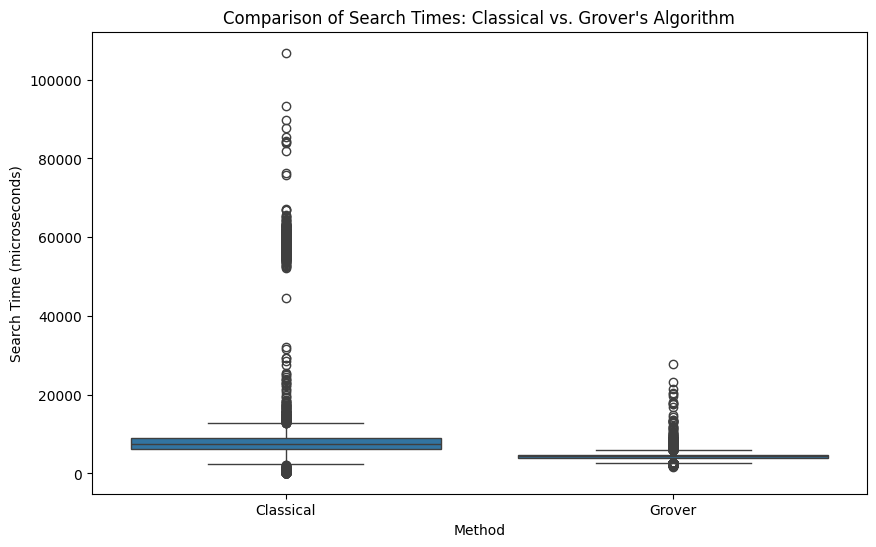

In [28]:
# Function to retrieve 'TimeTaken' values from the MongoDB collection
def get_search_times(collection_name):
    collection = db[collection_name]
    search_results = collection.find()  # Retrieve all documents from the collection
    # Use 'TimeTaken' or another field name that you find in the document structure
    times = [record.get('TimeTaken', 0) for record in search_results]  # Use 0 if 'TimeTaken' is missing
    return times

# Retrieve search times from the collections
classical_times_50 = get_search_times('classical_search_50')
classical_times_500 = get_search_times('classical_search_500')
classical_times_5000 = get_search_times('classical_search_5000')

grover_times_50 = get_search_times('grover_search_50')
grover_times_500 = get_search_times('grover_search_500')
grover_times_5000 = get_search_times('grover_search_5000')

# Combine the search times into one list
classical_times = classical_times_50 + classical_times_500 + classical_times_5000
grover_times = grover_times_50 + grover_times_500 + grover_times_5000

# Create a DataFrame for both classical and Grover search methods
df_comparison = pd.DataFrame({
    'Search Time (microseconds)': classical_times + grover_times,
    'Method': ['Classical'] * len(classical_times) + ['Grover'] * len(grover_times)
})

# Calculate the average time for each method
average_classical_time = sum(classical_times) / len(classical_times)
average_grover_time = sum(grover_times) / len(grover_times)

# Print the average times for comparison
print(f"Average time for Classical Search: {average_classical_time:.2f} microseconds")
print(f"Average time for Grover's Algorithm: {average_grover_time:.2f} microseconds")

# Plot comparison with boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x='Method', y='Search Time (microseconds)', data=df_comparison)
plt.title('Comparison of Search Times: Classical vs. Grover\'s Algorithm')
plt.ylabel('Search Time (microseconds)')
plt.show()


Boxplot: Comparison of Search Times
This boxplot shows the distribution of search times for Classical and Grover's algorithms across all dataset sizes.

Insights:
Classical search has a significantly higher median time and a wider spread, indicating more variability and slower performance overall.
Grover's algorithm exhibits a smaller spread and consistently faster search times.

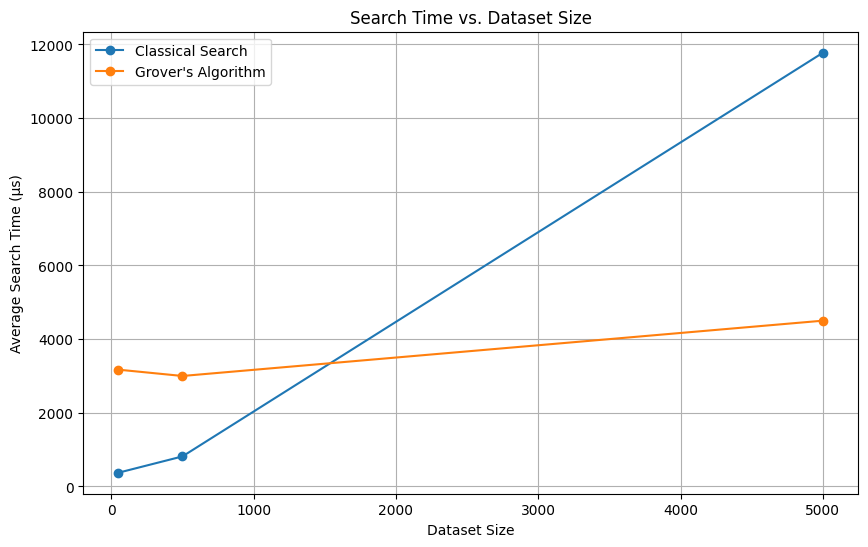

In [29]:
sizes = [50, 500, 5000]
classical_avg_times = [
    np.mean(classical_times_50),
    np.mean(classical_times_500),
    np.mean(classical_times_5000),
]
grover_avg_times = [
    np.mean(grover_times_50),
    np.mean(grover_times_500),
    np.mean(grover_times_5000),
]

plt.figure(figsize=(10, 6))
plt.plot(sizes, classical_avg_times, label="Classical Search", marker="o")
plt.plot(sizes, grover_avg_times, label="Grover's Algorithm", marker="o")
plt.xlabel("Dataset Size")
plt.ylabel("Average Search Time (µs)")
plt.title("Search Time vs. Dataset Size")
plt.legend()
plt.grid()
plt.show()


 Line Graph: Search Time vs. Dataset Size
This graph compares the average search time for both algorithms as the dataset size increases (50, 500, 5000).

Insights:
Classical search shows a linear increase in search time, consistent with its O(N) complexity.
Grover's algorithm grows much slower, following its O(√N) complexity.
The gap between the two algorithms widens as the dataset size increases, demonstrating Grover's advantage for larger datasets.


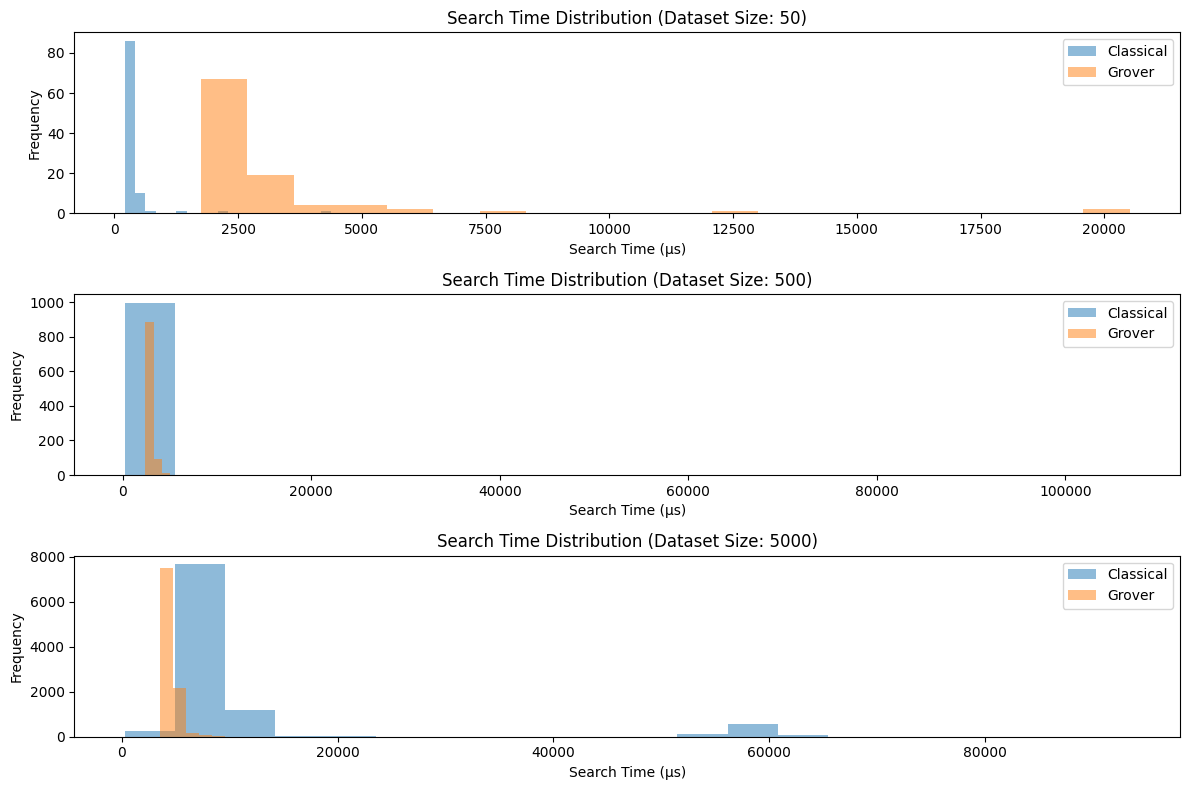

In [30]:
plt.figure(figsize=(12, 8))
for i, (classical, grover, size) in enumerate(
    zip([classical_times_50, classical_times_500, classical_times_5000],
        [grover_times_50, grover_times_500, grover_times_5000],
        sizes)):
    plt.subplot(3, 1, i + 1)
    plt.hist(classical, alpha=0.5, label="Classical", bins=20)
    plt.hist(grover, alpha=0.5, label="Grover", bins=20)
    plt.title(f"Search Time Distribution (Dataset Size: {size})")
    plt.xlabel("Search Time (µs)")
    plt.ylabel("Frequency")
    plt.legend()
plt.tight_layout()
plt.show()


Histograms: Search Time Distributions for Each Dataset Size
Each subplot compares the distributions of search times for Classical and Grover's algorithms for dataset sizes 50, 500, and 5000.

Insights:
Classical search has a broader and more variable distribution across all dataset sizes.
Grover's algorithm has tighter distributions, with fewer extreme values.
For larger datasets, Classical search times shift significantly higher, while Grover's remain more stable.